In [1]:
start_date = "2024-10-18"
end_date = "2024-10-22"

In [2]:
import json
from datetime import datetime
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MinuteLocator

import numpy as np
import pandas as pd

from IPython.display import display, HTML

Read log data from Loki

In [33]:
def get_loki_data():
    command = f"""/sdf/group/rubin/user/jeremym/ppdb-replication/bin/logcli-linux-amd64 --tls-skip-verify query --addr=http://sdfloki.slac.stanford.edu:80 --proxy-url=http://sdfproxy.sdf.slac.stanford.edu:3128 --timezone=UTC -o raw --limit=20000 --batch=1000 --from={start_date}T00:00:00Z --to={end_date}T00:00:00Z '{{namespace="vcluster--usdf-rsp-dev", container="ppdb-replication"}}'"""
    print(f"Running command:\n{command}")
    results = !{command}
    return results

In [34]:
results = get_loki_data()
#results[0:5]
print(f"Loki returned {len(results)} records")
# results

Running command:
/sdf/group/rubin/user/jeremym/ppdb-replication/bin/logcli-linux-amd64 --tls-skip-verify query --addr=http://sdfloki.slac.stanford.edu:80 --proxy-url=http://sdfproxy.sdf.slac.stanford.edu:3128 --timezone=UTC -o raw --limit=20000 --batch=1000 --from=2024-10-18T00:00:00Z --to=2024-10-22T00:00:00Z '{namespace="vcluster--usdf-rsp-dev", container="ppdb-replication"}'
Loki returned 16360 records


In [5]:
def get_log_records(log_lines):
    """
    Parse the raw log lines into a list of dicts.
    """
    log_records = []
    mon_logger = "lsst.dax.ppdb.monitor"
    offset = len(mon_logger) + 3
    for line in log_lines:    
        if mon_logger in line:
            if line.startswith("Running:"):
                continue
            idx = line.find(mon_logger)
            if idx != -1:
                try:
                    log_data = json.loads(line[idx+offset:])
                except:
                    raise ValueError(f"Error loading JSON: {line[idx+offset:]}")
                log_records.append(log_data)
    return log_records

In [6]:
log_records = get_log_records(results)

DataFrame utilities

In [7]:
def create_df(_log_records):
    """
    Convert the log records into a DataFrame.
    """
    
    print(f"Converting {len(_log_records)} log records to Data Frame")
    
    _df = pd.DataFrame({
        "timestamp": pd.Series(dtype="datetime64[ns]"),
        "table": pd.Series(dtype="str"),
        "chunk_id": pd.Series(dtype="int"),
        "name": pd.Series(dtype="str"),
        "source": pd.Series(dtype="str"),
        "real_time": pd.Series(dtype="float"),
        "user_time": pd.Series(dtype="float"),
        "sys_time": pd.Series(dtype="float"),
        "row_count": pd.Series(dtype="int"),
        "file_size": pd.Series(dtype="int")        
    })
    
    for _rec in _log_records:
        if any(k not in _rec for k in ["name", "values", "tags"]):
            print(f"Invalid log record: {log_record}")
            continue
        tags = _rec["tags"]
        values = _rec["values"]
        _df.loc[len(_df)] = [
                pd.to_datetime(_rec["timestamp"], unit='s'),
                tags.get("table", None),
                tags.get("chunk_id", None),
                _rec["name"],
                _rec.get("source", None),
                values.get("real", None),
                values.get("user", None),
                values.get("sys", None),
                values.get("row_count", None),
                values.get("file_size", None)
            ]
    return _df

def filter_df(_df, tables=[], fields=[]):
    """
    Filter a DataFrame on a list of tables and/or fields.
    """
    if len(tables) > 0:
        _df = _df[_df['table'].isin(tables)]
    
    if len(fields) > 0:
        _df = _df[_df['name'].isin(fields)]
    
    return _df

def print_uniq(_df):
    """
    Print the unique values for important string fields.
    """
    for colname in ["table", "name", "source"]:
        print(f"Unique {colname}:" + str(_df[colname].unique()))

def uniq_df(_df):
    """
    Create a DataFrame for displaying unique fields of string fields.
    """
    
    # Columns of interest
    columns = ['table', 'name', 'source']
    
    # Create a dictionary to store the unique values for each column
    unique_values = {}
    
    # Loop through each column, get unique values, sort them, and store them in the dictionary
    for col in columns:
        unique_values[col] = sorted([x for x in _df[col].unique() if x is not None])
    
    # Find the maximum length among the lists
    max_length = max(len(values) for values in unique_values.values())
    
    # Pad each list with empty strings to match the max length
    for col in unique_values:
        unique_values[col] += [''] * (max_length - len(unique_values[col]))
    
    # Create a DataFrame with the padded unique values
    unique_values_df = pd.DataFrame({
        'table': unique_values['table'],
        'name': unique_values['name'],
        'source': unique_values['source']
    })

    # Reset index to hide the default index
    return unique_values_df.reset_index(drop=True)

In [8]:
df = create_df(log_records)
print(f"Created DataFrame with {len(df)} records")
orig_df = df.copy()

Converting 7702 log records to Data Frame
Created DataFrame with 7702 records


In [9]:
FILE_NAME = "replication_metrics.csv"
orig_df.to_csv(FILE_NAME)
print(f"Wrote DataFrame to: {FILE_NAME}")

Wrote DataFrame to: replication_metrics.csv


In [10]:
df

,timestamp,table,chunk_id,name,source,real_time,user_time,sys_time,row_count,file_size
0,2024-10-21 19:32:34.725021124,None,None,chunks_select_time,lsst.dax.apdb.cassandra.apdbCassandraReplica,0.005603,0.001155,0.000000,359,None
1,2024-10-21 19:26:34.621279478,None,None,chunks_select_time,lsst.dax.apdb.cassandra.apdbCassandraReplica,0.005561,0.001149,0.000003,359,None
2,2024-10-21 19:20:34.533212185,None,None,chunks_select_time,lsst.dax.apdb.cassandra.apdbCassandraReplica,0.005919,0.001225,0.000000,359,None
3,2024-10-21 19:14:34.444220066,None,None,chunks_select_time,lsst.dax.apdb.cassandra.apdbCassandraReplica,0.004780,0.001206,0.000000,359,None
4,2024-10-21 19:08:34.354396105,None,None,chunks_select_time,lsst.dax.apdb.cassandra.apdbCassandraReplica,0.005846,0.000333,0.000946,359,None
...,...,...,...,...,...,...,...,...,...,...
7697,2024-10-18 00:25:52.520587444,None,None,chunks_select_time,lsst.dax.apdb.cassandra.apdbCassandraReplica,0.004124,0.000851,0.000000,128,None
7698,2024-10-18 00:19:52.482825279,None,None,chunks_select_time,lsst.dax.apdb.cassandra.apdbCassandraReplica,0.004078,0.000858,0.000000,128,None
7699,2024-10-18 00:13:52.445393324,None,None,chunks_select_time,lsst.dax.apdb.cassandra.apdbCassandraReplica,0.004191,0.000000,0.000950,128,None
7700,2024-10-18 00:07:52.407846212,None,None,chunks_select_time,lsst.dax.apdb.cassandra.apdbCassandraReplica,0.003871,0.001034,0.000001,128,None


Display unique field values:

In [11]:
display(uniq_df(df))

,table,name,source
0,DiaForcedSource,chunks_select_time,lsst.dax.apdb.cassandra.apdbCassandra
1,DiaForcedSourceChunks,cluster_connect,lsst.dax.apdb.cassandra.apdbCassandraReplica
2,DiaObject,get_chunks_time,lsst.dax.ppdb.replicator
3,DiaObjectChunks,pg_bindump_time,lsst.dax.ppdb.sql._ppdb_sql
4,DiaSource,pg_bulk_insert_time,lsst.dax.ppdb.sql.bulk_insert
5,DiaSourceChunks,read_metadata_config,
6,,replicate_chunk_time,
7,,store_chunks_time,
8,,store_data_time,
9,,table_chunk_select_time,


In [12]:
STANDARD_TABLE_NAMES = ["DiaObject", "DiaSource", "DiaForcedSource"]
# CHUNK_TABLE_NAMES = [f"{name}Chunks" for name in STANDARD_TABLE_NAMES]  # currently unused

In [13]:
# Filter the primary DataFrame to get relevant rows for update and store metrics.
df = filter_df(df, 
               tables=STANDARD_TABLE_NAMES, 
               fields=["update_validity_time", "store_data_time"])
print(f"Filtered to {len(df)} update and store records")

Filtered to 1436 update and store records


In [23]:
import matplotlib.pyplot as plt
import math

def get_unit(value_name):
    """
    Return the unit for a given field.
    """
    if value_name in ["real_time", "user_time", "sys_time"]:
        return "s"
    elif value_name == "file_size":
        return "bytes"
    else:
        return None

def plot_ts_value(ax, ts, value, table_name, name):
    """
    Plot a timestamp against a value.
    """
    if ts[value].notna().sum() == 0:  # Guard against plotting if no valid data exists
        ax.set_visible(False)  # Hide the subplot if there's no data
        return
    
    ax.plot(ts["timestamp"], ts[value], marker='o', linestyle="-", color='b', markersize=0, linewidth=1)
    # ax.set_xlabel('Timestamp')
    unit = get_unit(value)
    ylabel = value.replace("_", " ").title()
    if unit:
        ylabel += f" [{unit}]"
    ax.set_ylabel(ylabel)
    title_name = name.replace("_", " ").title()
    ax.set_title(f"{table_name} - {title_name}")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)

def ts_plots(_df, values):
    """
    Create a matrix of plots by table and name.
    """
    if len(_df) < 1:
        raise ValueError("No data to plot in DataFrame")
    
    # Calculate the total number of plots and the number of rows needed
    total_plots = len(_df['table'].unique()) * len(_df['name'].unique()) * len(values)
    rows = math.ceil(total_plots / 2)  # 2 plots per row

    # Create a 2xN grid of subplots
    fig, axs = plt.subplots(rows, 2, figsize=(14, rows * 5))
    axs = axs.flatten()  # Flatten the 2D array of axes for easy indexing
    
    plot_idx = 0  # Track which subplot we are working with
    for table in _df['table'].unique():
        for name in _df['name'].unique():
            plot_df = _df[(_df['table'] == table) & (_df['name'] == name)]
            if len(plot_df) > 0:
                for value in values:
                    # Only plot if there is data for the given value
                    if plot_df[value].notna().sum() > 0:  # Check if there's any non-NaN data
                        plot_ts_value(axs[plot_idx], plot_df, value, table, name)
                        plot_idx += 1

    # Hide unused subplots (if there are any left after plotting)
    for i in range(plot_idx, len(axs)):
        axs[i].set_visible(False)
    
    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()

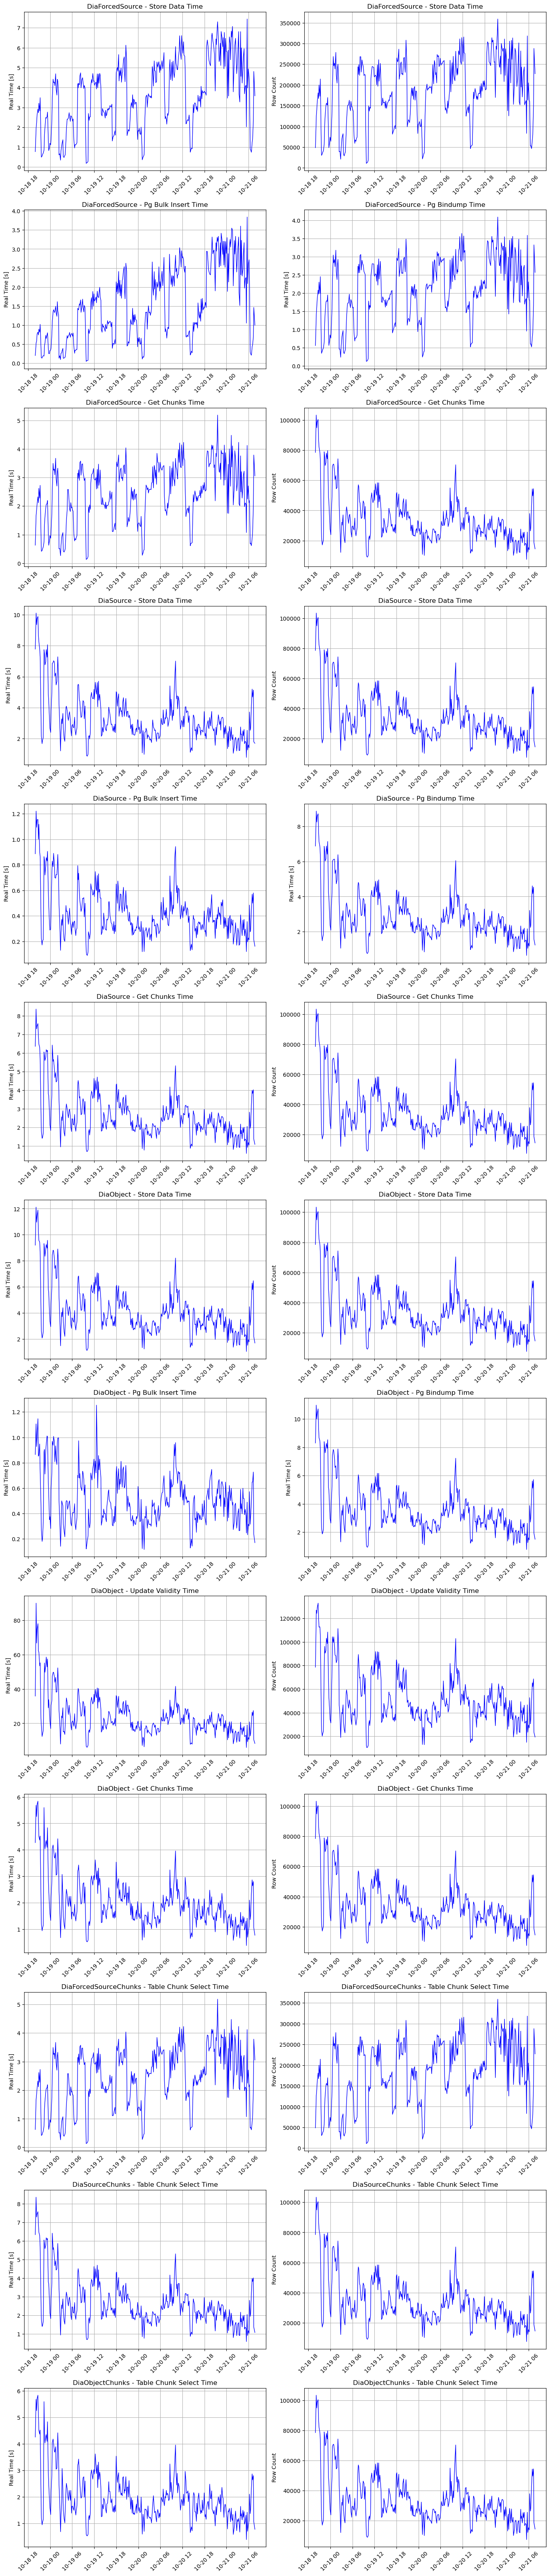

In [24]:
ts_plots(df, ["real_time", "row_count"])

In [25]:
def get_ts_diff(_df):

    # Get the minimum and maximum values from the 'timestamp' column
    min_timestamp = _df['timestamp'].min()
    max_timestamp = _df['timestamp'].max()
    
    # Calculate the difference
    time_diff = max_timestamp - min_timestamp

    return time_diff

def print_ts_diff(_df):

    time_diff = get_ts_diff(_df)

    # Extract total seconds
    total_seconds = time_diff.total_seconds()
    
    # Calculate hours, minutes, and remaining seconds
    hours = int(total_seconds // 3600)
    minutes = int((total_seconds % 3600) // 60)
    seconds = int(total_seconds % 60)
    
    # Print the result
    print(f"{hours}h{minutes}m{seconds}s")

In [26]:
print_ts_diff(df)

91h30m42s


In [27]:
summary_df = df.groupby(['table', 'name'])[['real_time', 'row_count']].sum().reset_index()
rows_per_s = summary_df['row_count'] / get_ts_diff(df).total_seconds()
rows_per_s = rows_per_s.round(0).astype(int)
summary_df['Rows per s'] = rows_per_s
summary_df['real_time'] = summary_df['real_time'].round(2)
summary_df.style.hide(axis='index')

table,name,real_time,row_count,Rows per s
DiaForcedSource,get_chunks_time,879.180000,12222552,37
DiaForcedSource,pg_bindump_time,756.530000,0,0
DiaForcedSource,pg_bulk_insert_time,546.420000,0,0
DiaForcedSource,store_data_time,1307.810000,66429243,201
DiaForcedSourceChunks,table_chunk_select_time,879.110000,66429243,201
DiaObject,get_chunks_time,718.200000,12222552,37
DiaObject,pg_bindump_time,1283.290000,0,0
DiaObject,pg_bulk_insert_time,185.470000,0,0
DiaObject,store_data_time,1478.100000,12222552,37
DiaObject,update_validity_time,8498.810000,18415424,55


In [28]:
df = orig_df

In [29]:
pg_df = filter_df(orig_df, tables=STANDARD_TABLE_NAMES, fields=["pg_bulk_insert_time"])
# pg_df.style.hide(axis='index')

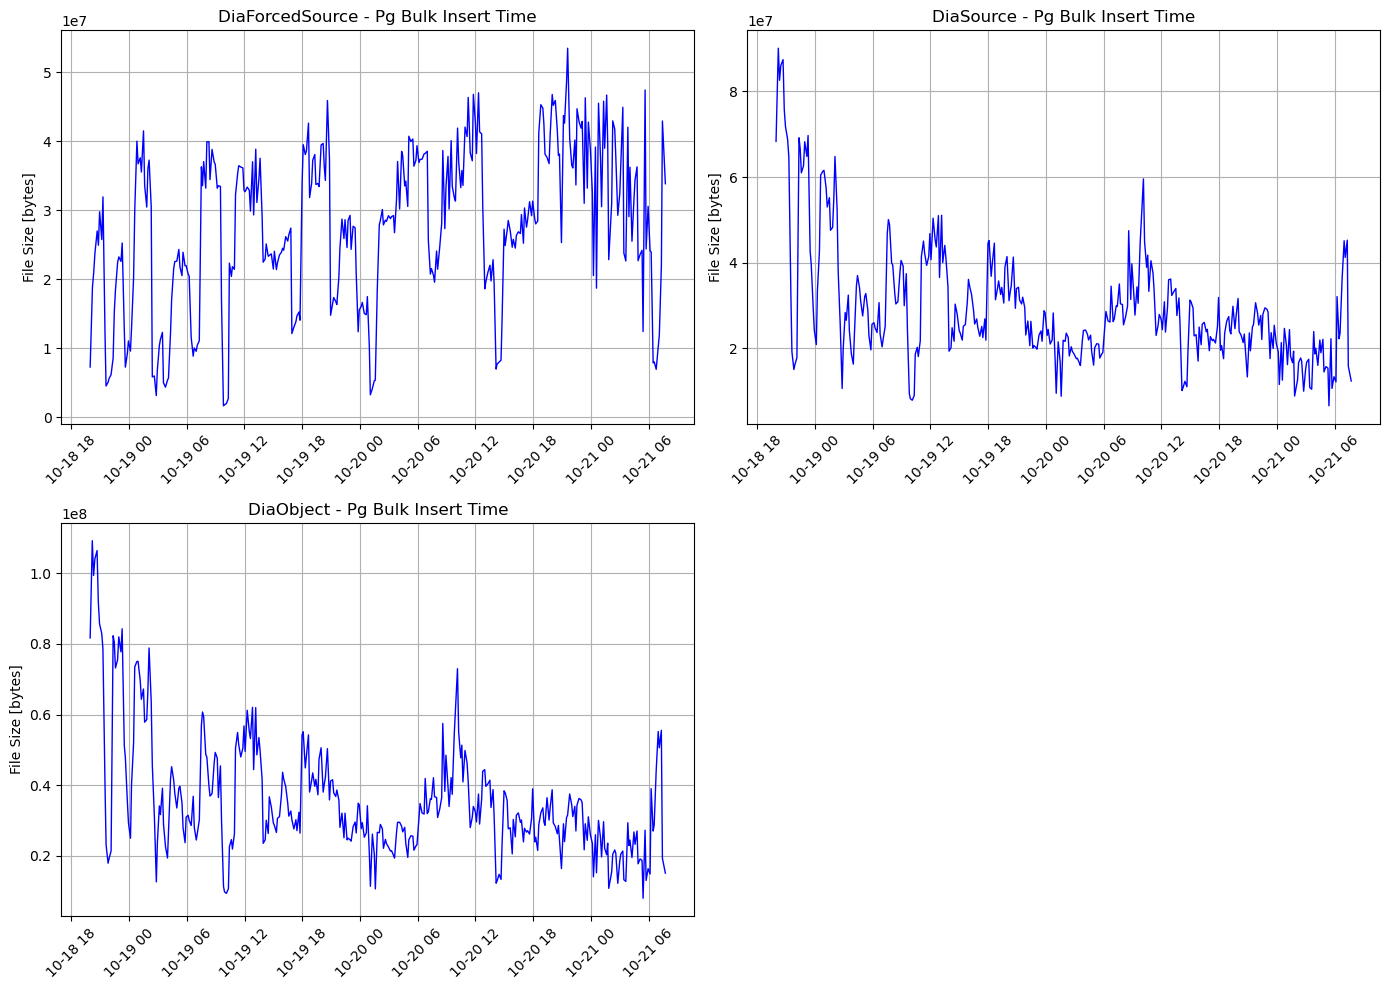

In [30]:
ts_plots(pg_df, ["file_size"])

In [31]:
pg_summary_df = pg_df.groupby(['table', 'name'])[['file_size']].sum().reset_index()

bytes_per_s = pg_summary_df['file_size'] / get_ts_diff(pg_df).total_seconds()
pg_summary_df['file_size'] = (pg_summary_df['file_size'] / (1024 ** 3)).round(2)

bytes_per_s = bytes_per_s.round(0).astype(int)
pg_summary_df['bytes_per_s'] = bytes_per_s
pg_summary_df['Kb per s'] = pg_summary_df['bytes_per_s'] / 1024
pg_summary_df = pg_summary_df.round(2)
pg_summary_df.style.hide(axis='index')

pg_summary_df.rename(columns={'table': 'Table', 'name': 'Operation', 'file_size': 'Total Copied (Gb)', 'bytes_per_s': 'Bytes per s'}, inplace=True)
display(pg_summary_df[['Table', 'Operation', 'Total Copied (Gb)', 'Kb per s']])

,Table,Operation,Total Copied (Gb),Kb per s
0,DiaForcedSource,pg_bulk_insert_time,9.215139,44.89
1,DiaObject,pg_bulk_insert_time,12.026905,58.59
2,DiaSource,pg_bulk_insert_time,9.878923,48.12
